In [73]:
import torch
from torch import nn
from torch.distributions import Categorical
from torch.distributions import MultivariateNormal
from tqdm import tqdm

from IPython.display import clear_output
import matplotlib.pyplot as plt
import time

In [122]:
from targets.variational_inference_target import Orbits
target = Orbits()

In [130]:
class AnnealedSMC(nn.Module):
    def __init__(self, target_log_density,d,T, initial_distribution=None):
        super().__init__()
        self.target_log_density = target_log_density
        self.d = d
        self.T = T
        if initial_distribution is None: 
            self.initial_distribution = torch.distributions.MultivariateNormal(torch.randn(self.d), torch.eye(self.d))
        else:
            self.initial_distribution = initial_distribution
            
        self.target_log_densities = lambda samples,t:self.target_log_density(samples)*t + self.initial_distribution.log_prob(samples)*(self.T-t)

    def log_Q(self, target_log_density, x_prime, x, tau):
        x.requires_grad_()
        grad = torch.autograd.grad(torch.sum(target_log_density(x), dim = 0), x)[0]
        return MultivariateNormal(x+tau*grad,2*tau*torch.eye(x.shape[-1])).log_prob(x_prime)

    def metropolis_adjusted_langevin_step(self,target_log_density, x, tau):
        x.requires_grad_()
        grad = torch.autograd.grad(torch.sum(target_log_density(x), dim=0), x)[0]
        new_x = x + tau*grad + (2*tau)**(1/2)*torch.randn(x.shape)
        mask = torch.rand(x.shape[0])<torch.exp(target_log_density(new_x) - target_log_density(x) + self.log_Q(target_log_density,x, new_x, tau) - self.log_Q(target_log_density,new_x, x, tau))
        return mask.unsqueeze(-1).repeat(1,self.d).int()*new_x + (1-mask.unsqueeze(-1).repeat(1,self.d).int())*x

    def propagate_particles(self,particles, K,t):
        for k in range(1,K+1):
            particles = self.metropolis_adjusted_langevin_step(target_log_density=lambda samples: self.target_log_densities(samples,t), x = particles,tau = float(1/(k*self.d)))
        return particles

    def resample_particles(self, propagated_particles,weights):
        pick = Categorical(weights).sample([propagated_particles.shape[0]])
        return torch.stack([propagated_particles[pick[i],:] for i in range(propagated_particles.shape[0])])

    def reweight_particles(self,resampled_particles,t):
        unormalized_log_weights = self.target_log_densities(resampled_particles, t+1) - torch.log(torch.tensor([resampled_particles.shape[0]])) - self.target_log_densities(resampled_particles,t)
        return torch.exp(unormalized_log_weights - torch.logsumexp(unormalized_log_weights, dim = 0) )

    def sample(self, number_particles):
        list_particles = [self.initial_distribution.sample([number_particles])]
        list_weights = [torch.ones(number_particles)/number_particles]
        for t in tqdm(range(1,self.T)):
            propagated_particles = self.propagate_particles(list_particles[-1],10,t)
            resampled_particles = self.resample_particles(propagated_particles,list_weights[-1])
            list_particles.append(resampled_particles)
            weights = self.reweight_particles(resampled_particles,t)
            list_weights.append(weights)
        return list_particles, list_weights

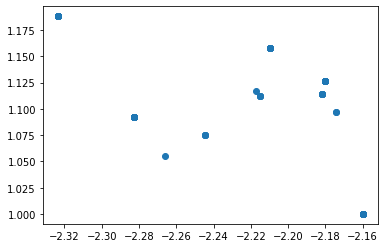

In [131]:
sampler = AnnealedSMC(target.log_prob,2,20)
list_particles, list_weights = sampler.sample(1000)
for particles_set in list_particles:
    plt.scatter(particles_set[:,0].detach().numpy(),particles_set[:,1].detach().numpy())
    clear_output(wait = True)
    plt.show()

In [117]:
class SMCSampler1(nn.Module):
    def __init__(self, target_log_densities,x0, w0):
        super().__init__()
        self.particles = [x0]
        self.weights = [w0]
        self.N = x0.shape[0]
        self.d = x0.shape[1]
        assert w0.shape[0] == self.N, 'number of weights is different from number of particles'
        self.T = len(target_log_densities)
        self.target_log_densities = target_log_densities

    def log_Q(self, target_log_density, x_prime, x, tau):
        x.requires_grad_()
        grad = torch.autograd.grad(torch.sum(target_log_density(x), dim = 0), x)[0]
        return MultivariateNormal(x+tau*grad,2*tau*torch.eye(x.shape[-1])).log_prob(x_prime)

    def metropolis_adjusted_langevin_step(self,target_log_density, x, tau):
        x.requires_grad_()
        grad = torch.autograd.grad(torch.sum(target_log_density(x), dim=0), x)[0]
        new_x = x + tau*grad + (2*tau)**(1/2)*torch.randn(x.shape)
        mask = torch.rand(self.N)<torch.exp(target_log_density(new_x) - target_log_density(x) + self.log_Q(target_log_density,x, new_x, tau) - self.log_Q(target_log_density,new_x, x, tau))
        return mask.unsqueeze(-1).repeat(1,self.d).int()*new_x + (1-mask.unsqueeze(-1).repeat(1,self.d).int())*x

    def propagate_particles(self, K,t):
        current_particles = self.particles[t]
        for k in range(1,K+1):
            current_particles = self.metropolis_adjusted_langevin_step(target_log_density=self.target_log_densities[t], x = current_particles,tau = float(1/(k*self.d)))
        return current_particles

    def resample_particles(self, propagated_particles,t):
        pick = Categorical(self.weights[t]).sample([self.N])
        self.particles.append(torch.stack([propagated_particles[pick[i], :] for i in range(self.N)]))

    def reweight_particles(self,t):
        resampled_particles = self.particles[t+1]
        unormalized_log_weights = self.target_log_densities[t+1](resampled_particles) - torch.log(torch.tensor([self.N])) - self.target_log_densities[t](resampled_particles)
        normalized_weights = torch.exp(unormalized_log_weights - torch.logsumexp(unormalized_log_weights, dim = 0) )
        self.weights.append(normalized_weights)

    def sample(self):
        for t in tqdm(range(self.T-1)):
            propagated_particles = self.propagate_particles(50,t)
            self.resample_particles(propagated_particles,t)
            self.reweight_particles(t)

In [18]:
N = 1000
x0 = torch.randn(N,2)
w0 = torch.ones(N)/N
T = 20
target_log_densities = [lambda samples: i*target.log_prob(samples) + MultivariateNormal(torch.zeros(2), torch.eye(2)).log_prob(samples)*(T-i) for i in range(T)]
smc = SMCSampler1(target_log_densities, x0, w0)
smc.sample()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.02s/it]


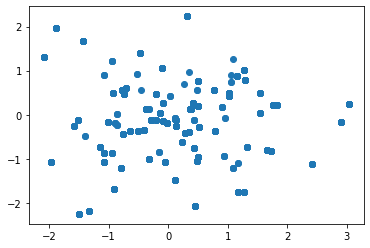

In [19]:
linspace= torch.linspace(-5, 15,1000).unsqueeze(-1)
for i,particle_set in enumerate(smc.particles):
    clear_output(wait=True)
    plt.figure()
    plt.scatter(particle_set[:,0].detach().numpy(), particle_set[:,1].detach().numpy())
    plt.show()

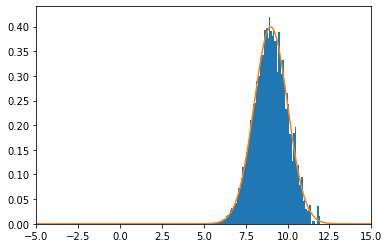

In [4]:
linspace= torch.linspace(-5, 15,1000).unsqueeze(-1)
for i,particle_set in enumerate(smc.particles):
    clear_output(wait=True)
    plt.figure()
    plt.hist(particle_set.detach().numpy(), bins= 100, density = True,weights = smc.weights[i].detach().numpy())
    plt.plot(linspace, torch.exp(target_log_densities[i](linspace)))
    plt.xlim((-5,15))
    plt.show()

In [14]:
class SMCSampler2(nn.Module):
    def __init__(self, target_log_densities,x0, w0):
        super().__init__()
        self.particles = [x0]
        self.weights = [w0]
        self.N = x0.shape[0]
        self.d = x0.shape[1]
        assert w0.shape[0] == self.N, 'number of weights is different from number of particles'
        self.T = len(target_log_densities)
        self.target_log_densities = target_log_densities

    def log_Q(self, target_log_density, x_prime, x, tau):
        x.requires_grad_()
        grad = torch.autograd.grad(torch.sum(target_log_density(x), dim = 0), x)[0]
        return MultivariateNormal(x+tau*grad,2*tau*torch.eye(x.shape[-1])).log_prob(x_prime)

    def metropolis_adjusted_langevin_step(self,target_log_density, x, tau):
        x.requires_grad_()
        grad = torch.autograd.grad(torch.sum(target_log_density(x), dim=0), x)[0]
        new_x = x + tau*grad + (2*tau)**(1/2)*torch.randn(x.shape)
        mask = torch.rand(self.N)<torch.exp(target_log_density(new_x) - target_log_density(x) + self.log_Q(target_log_density,x, new_x, tau) - self.log_Q(target_log_density,new_x, x, tau))
        return mask.unsqueeze(-1).repeat(1,self.d).int()*new_x + (1-mask.unsqueeze(-1).repeat(1,self.d).int())*x

    def propagate_particles(self, K,t):
        propagated_particles = self.particles[t]
        for k in range(1,K+1):
            propagated_particles = self.metropolis_adjusted_langevin_step(target_log_density=self.target_log_densities[t+1], x = propagated_particles,tau = float(1/(k*self.d)))
        return propagated_particles

    def reweight_resample_particles(self,propagated_particles,t):
        #reweight
        current_particles = self.particles[t]
        current_weights = self.weights[t]
        unormalized_log_weights = self.target_log_densities[t+1](current_particles) +torch.log(current_weights) - self.target_log_densities[t](current_particles)
        normalized_weights = torch.exp(unormalized_log_weights - torch.logsumexp(unormalized_log_weights, dim = 0))
        #resample
        pick = Categorical(normalized_weights).sample([self.N])
        self.particles.append(torch.stack([propagated_particles[pick[i], :] for i in range(self.N)]))
        self.weights.append(torch.ones(self.N)/self.N)

    def sample(self):
        for t in tqdm(range(self.T-1)):
            propagated_particles = self.propagate_particles(500,t)
            self.reweight_resample_particles(propagated_particles,t)

In [15]:
smc = SMCSampler2(target_log_densities, x0, w0)
smc.sample()

  5%|███████▉                                                                                                                                              | 1/19 [00:53<16:00, 53.33s/it]


KeyboardInterrupt: 

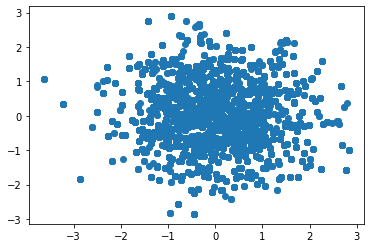

In [13]:
linspace= torch.linspace(-5, 15,1000).unsqueeze(-1)
for i,particle_set in enumerate(smc.particles):
    clear_output(wait=True)
    plt.figure()
    plt.scatter(particle_set[:,0].detach().numpy(), particle_set[:,1].detach().numpy())
    plt.show()

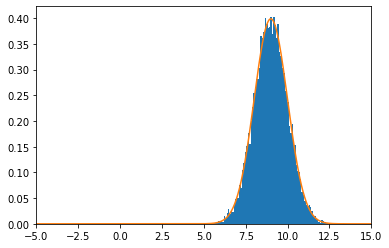

In [7]:
linspace= torch.linspace(-5, 15,1000).unsqueeze(-1)
for i,particle_set in enumerate(smc.particles):
    clear_output(wait=True)
    plt.figure()
    plt.hist(particle_set.detach().numpy(), bins= 100, density = True,weights = smc.weights[i].detach().numpy())
    plt.plot(linspace, torch.exp(target_log_densities[i](linspace)))
    plt.xlim((-5,15))
    plt.show()